<img src="./images/ibm-logo.png" alt="ibm-logo" align="center" style="width: 200px;"/>

**Advanced Data Science with IBM**

<hr />

### Capstone Project


# Use Case and Data Source

**Project Description**

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. Take this example:

<img src="./images/tweet_screenshot.png" alt="tweet_screenshot" align="center" style="width: 200px;"/>

The author explicitly uses the word “ABLAZE” but means it metaphorically. This is clear to a human right away, especially with the visual aid. But it’s less clear to a machine. The objective of this project is to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.

**Dataset**

The dataset is open source and is available on [kaggle](https://www.kaggle.com/vstepanenko/disaster-tweets). It contains over 11,000 tweets associated with disaster keywords like “crash”, “quarantine”, and “bush fires” as well as the location and keyword itself.

The tweets were collected on Jan 14th, 2020.

Some of the topics people were tweeting:

* The eruption of Taal Volcano in Batangas, Philippines
* Coronavirus
* Bushfires in Australia
* Iran downing of the airplane flight PS752

Disclaimer: The dataset contains text that may be considered profane, vulgar, or offensive.

# Initial Data Exploration

**What files do I need?**

I used the kaggle API to fetch the file *tweets.csv*. I created an API token to get the kaggle.json file and then from my local directory I ran the command:

`kaggle datasets download -d vstepanenko/disaster-tweets`

**What should I expect the data format to be?**

Each sample in the dataset has the following information:

* The text of a tweet
* A keyword from that tweet (although this may be blank!)
* The location the tweet was sent from (may also be blank)

**What am I predicting?**

I am predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.


**Columns**

* `id` - a unique identifier for each tweet
* `text` - the text of the tweet
* `location` - the location the tweet was sent from (may be blank)
* `keyword` - a particular keyword from the tweet (may be blank)
* `target` - this denotes whether a tweet is about a real disaster (1) or not (0)

In [1]:
%%writefile risk_tweets_nlp_data_exploration.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

DATA_DIR = os.path.join(".","data")
IMAGE_DIR = os.path.join(".","images")

def save_fig(fig_id, tight_layout=True, image_path=IMAGE_DIR):
    """
    save the image as png file in the image directory
    """
    
    ## Check the data directory
    if not os.path.exists(image_path):
        os.makedirs(image_path)
    
    path = os.path.join(image_path, fig_id + ".png")
    print("...saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

def ingest_data(datadir=DATA_DIR, filename="tweets.csv"):
    """
    ingest tweets dataset
    """
    
    print("Ingesting Data")
    
    ## load csv file from data directory
    tweets = pd.read_csv(os.path.join(datadir,filename))
    
    ## dataframe structure
    print("...dataset of {} rows and {} columns".format(tweets.shape[0], tweets.shape[1]))
        
    ## check duplicates
    is_duplicate = tweets.duplicated(subset=["id"])
    print("...number of duplicates:", len(tweets[is_duplicate]))
    
    ## check missing data
    total = tweets.isnull().sum().sort_values(ascending=False)
    percent = (tweets.isnull().sum()/tweets.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    print("...missing values: \n {}".format(missing_data.head()))
    
    return tweets

def summarize_data(corpus, preprocessing=True):
    """
    print statements and visualizations to summarize the corpus
    """
    
    print("Summarize data")
    
    # get the documents size
    df_doc_size = pd.Series([len(str(doc).split(" ")) for doc in corpus])
    
    # get the tokens in the corpus
    df_tokens = pd.Series([token for doc in corpus for token in str(doc).split(" ")])
    
    print("---------------------------")
    print("num docs", len(corpus))
    print("median tokens", df_doc_size.median())
    print("num tokens", len(df_tokens))
    print("unique tokens", len(df_tokens.value_counts()))
    print("---------------------------")
    
    # make plots
    fig = plt.figure(figsize=(14,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    
    sns.distplot(df_doc_size, ax=ax1)
    ax1.set_title("Tweets Sizes")
    
    sns.distplot(df_tokens.value_counts().values, ax=ax2)
    ax2.set_title("Tokens Counts")
    
    if preprocessing:
        save_fig("summarize_data_preprocessing")
    else:
        save_fig("summarize_data_postprocessing")
    
if __name__ == "__main__":
    
    run_start = time.time()
    
    ## load tweets
    tweets = ingest_data()
    
    ## summarize data
    summarize_data(tweets.text.values.tolist())
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting risk_tweets_nlp_data_exploration.py


Ingesting Data
...dataset of 11370 rows and 5 columns
...number of duplicates: 0
...missing values: 
           Total   Percent
location   3418  0.300616
target        0  0.000000
text          0  0.000000
keyword       0  0.000000
id            0  0.000000
Summarize data
---------------------------
num docs 11370
median tokens 18.0
num tokens 195179
unique tokens 45250
---------------------------
...saving figure summarize_data_preprocessing
METADATA
...run time: 0:00:01
done


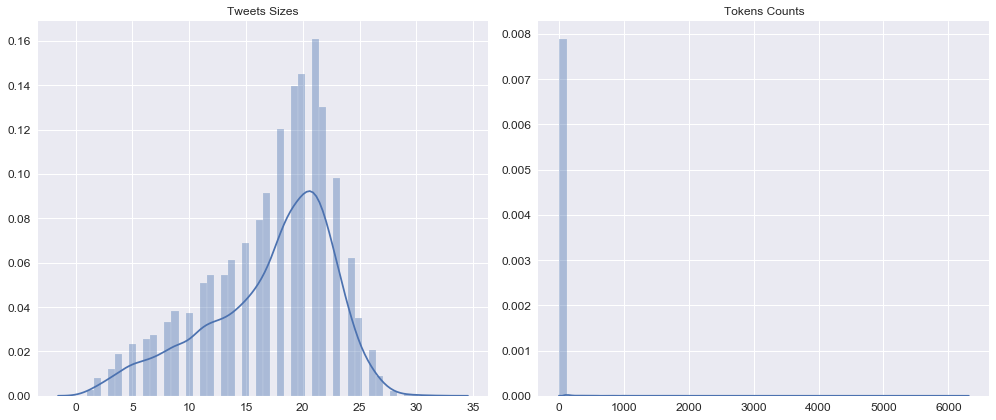

In [2]:
%run risk_tweets_nlp_data_exploration.py

### Findings from the Initial Data Exploration

Here are some findings from the initial data exploration:

* The dataset consists of 11370 rows and 5 columns
* There aren't any duplicate records in the dataset
* There are 3418 or 30% missing values in the column `location`
* The size of the tweets varies, and the median size is 18 tokens
* There are 195179 total tokens
* The unique tokens in the tweets corpus are 45250

# Extract Transform Load (ETL)

Process the data. There are many options to consider when you process the tokens from a corpus of text. These are some of the questions you might want to ask?

* Which stop words do I include?
* Which stemmer/lemmatizer is best?
* Which n-grams do I include?
* Do I filter based on frequency min and max?

There are many ways to process tokens (words, dates, emojis etc). NLTK is often used to pre-process text data before the tokens are vectorized. Generally, the tokens are modified via stemming or lemmatization.

Finally, I split the dataset into a train and test set, use the train set for modelling and the test set at the end to evaluate model generalized performance.

In [3]:
%%writefile risk_tweets_nlp_etl.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
from collections import Counter
import nltk
#nltk.download("all")
from nltk.stem import WordNetLemmatizer
from string import punctuation, printable
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

## imports from process model scripts
from risk_tweets_nlp_data_exploration import ingest_data, summarize_data
from risk_tweets_nlp_data_exploration import DATA_DIR

STOPLIST = ENGLISH_STOP_WORDS
STOPLIST = set(list(STOPLIST) + ["foo"])
SAVED_CORPUS = 'processed-corpus.npz'

def lemmatize_document(doc, stop_words=None):
    """
    Use the WordNetLemmatizer from nltk package
    """
    
    # create an instant of WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    if not stop_words:
        stop_words = set([])
    
    # ensure working with string
    doc = str(doc)
    
    # First remove punctuation from string
    if sys.version_info.major == 3:
        PUNCT_DICT = {ord(punc): None for punc in punctuation}
        doc = doc.translate(PUNCT_DICT)
        
    # remove unicode
    clean_doc = "".join([char for char in doc if char in printable])
    
    tokens = [lemmatizer.lemmatize(w.lower()) for w in clean_doc.split(" ") if len(w)>1]
    
    return " ".join([token for token in tokens if token not in stop_words])


def etl(clean=False, filename=SAVED_CORPUS, data_path=DATA_DIR, stop_list=STOPLIST):
    """
    load, clean, split and save the dataset
    """
    
    saved_corpus = os.path.join(data_path, filename)
    
    if (not os.path.exists(saved_corpus) or clean):
        
        ## data ingestion
        tweets = ingest_data()
    
        ## only the text and the target will be used from the dataset
        corpus = tweets.text.values
        target = tweets.target.values
        
        ## lemmatize
        print("ETL")
        time_start = time.time()
        processed_corpus = [lemmatize_document(tweet, stop_list) for tweet in corpus]
        
        ## split the dataset into training and test set
        train_data, test_data, y_train, y_test = train_test_split(processed_corpus, target,
                                                                  test_size=0.2, stratify=target, random_state=42)
        print("---------------------------")
        print("train", sorted(Counter(y_train).items()))
        print("test", sorted(Counter(y_test).items()))
        print("---------------------------")
        
        args = {'train_data':train_data,"y_train":y_train,"test_data":test_data,"y_test":y_test}
        np.savez_compressed(saved_corpus,**args)
        print("process time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))
        
    else:
        print("loading {} from file".format(saved_corpus))
        npz = np.load(saved_corpus)
        train_data, y_train = npz['train_data'], npz["y_train"]
        test_data, y_test = npz['test_data'], npz["y_test"]
    
    return train_data, y_train, test_data, y_test

if __name__ == "__main__":
    
    run_start = time.time()
    
    ## extract, transform load
    train_data, y_train, test_data, y_test = etl(clean=True)
    
    ## summarize data
    summarize_data(np.concatenate((train_data,test_data),axis=0), preprocessing=False)
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")


Overwriting risk_tweets_nlp_etl.py


Ingesting Data
...dataset of 11370 rows and 5 columns
...number of duplicates: 0
...missing values: 
           Total   Percent
location   3418  0.300616
target        0  0.000000
text          0  0.000000
keyword       0  0.000000
id            0  0.000000
ETL
---------------------------
train [(0, 7413), (1, 1683)]
test [(0, 1853), (1, 421)]
---------------------------
process time 00:00:03
Summarize data
---------------------------
num docs 11370
median tokens 10.0
num tokens 109323
unique tokens 26023
---------------------------
...saving figure summarize_data_postprocessing
METADATA
...run time: 0:00:04
done


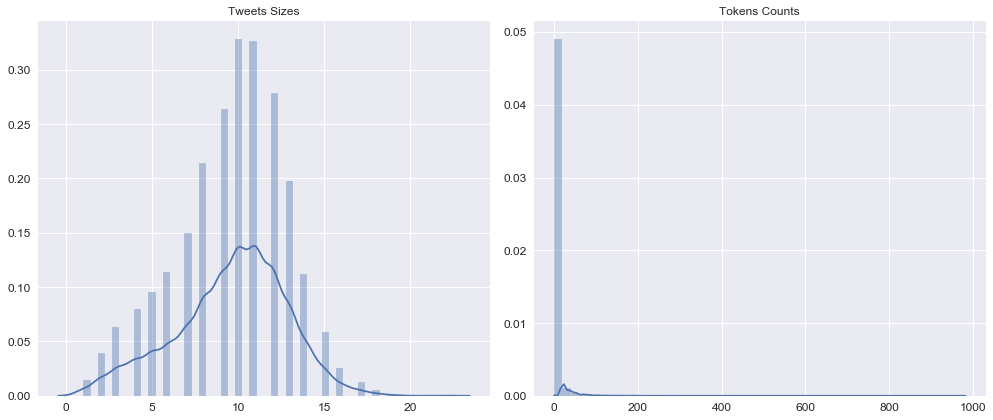

In [4]:
%run risk_tweets_nlp_etl.py

### Findings from the ETL

Here are some findings from the ETL process:

* The dataset consists of target value and the tweets
* I drop the columns `id`, `keyword` and `location`
* The target class is imbalanced, i.e. there are more instances of 0 than 1
* After lemmatization the size of the tweets in the corpus has changed. The median size now is 10 tokens
* There are 109323 total tokens
* The unique tokens in the tweets corpus are 26023

# Feature Engineering

A bag-of-words model is a representation of text. A document or sentence is represented as numeric counts of the individual words, without considering grammar and punctuation. Even the word order is ignored unless you expand your feature matrix with n-grams.

We can calculate various measures to characterize the text. The most common type matrix derived from the bag-of-words representation is term frequency (TF), which is the number of times a token appears in the text. Another useful matrix is the term frequency-inverse document frequency (tf-idf) matrix. There are variations on tf-idf and in general these derived matrices can be thought of as transforms that can be optimized in an iterative fashion.

I build a pipeline where the first step is CountVectorizer followed by TfidfTransformer.

Finally, TSNE dimensionality reduction techniques is used for visualization.

In [5]:
%%writefile risk_tweets_nlp_feature_engineering.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.manifold import TSNE
sns.set(style="ticks", color_codes=True)
plt.style.use('seaborn')

SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

## imports from process model scripts
from risk_tweets_nlp_etl import etl
from risk_tweets_nlp_data_exploration import save_fig
from risk_tweets_nlp_data_exploration import DATA_DIR

MODEL_DIR = os.path.join(".","models")
SAVED_MODEL = "my_sklearn_pipe.joblib"

def engineer_features(model_path=MODEL_DIR, model_name=SAVED_MODEL):
    """
    engineer text corpus
    """
    
    print("Engineering Features")
    
    ## etl
    train_data, y_train, test_data, y_test = etl()
    
    ## build transformation pipeline    
    feature_engineer = Pipeline([('counter', CountVectorizer(max_features=5000)),
                                 ('tfidf', TfidfTransformer())])
    
    ## fit on the training set
    feature_engineer.fit(train_data)
    
    ## transform training set
    X_train = feature_engineer.transform(train_data)
    print("training data dimensions {}".format(X_train.shape))
    
    ## save transformation pipeline
    saved_model = os.path.join(model_path, model_name)
    joblib.dump(feature_engineer, saved_model)
    
    
def create_feature_visualizations(model_path=MODEL_DIR, model_name=SAVED_MODEL):
    """
    use engineered features for visualizations
    """
    
    print("Create Features Visualizations")
    
    ## load the data
    train_data, y_train, test_data, y_test = etl()
    
    ## load transformation pipeline and transform training set
    feature_engineer = joblib.load(os.path.join(model_path, model_name))
    
    ## tsne dimensionality reduction for visualiazation
    X_count = feature_engineer.named_steps["counter"].transform(train_data)
    tsne = TSNE(n_components=2, random_state=42)
    X_2D = tsne.fit_transform(X_count)
    
    ## create 2D plot
    plt.figure(figsize=(10,8))
    plt.plot(X_2D[:, 0][y_train==1], X_2D[:, 1][y_train==1], "ro", label="real")
    plt.plot(X_2D[:, 0][y_train==0], X_2D[:, 1][y_train==0], "bo", label="no real")
    plt.axis('off')
    plt.legend(loc="upper left", fontsize=14)
    save_fig("tsne_visualization")

if __name__ == "__main__":
    
    run_start = time.time()
    
    ## feature engineering
    engineer_features()
    
    ## create 2D plot
    create_feature_visualizations()
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")
    

Overwriting risk_tweets_nlp_feature_engineering.py


Engineering Features
loading .\data\processed-corpus.npz from file
training data dimensions (9096, 5000)
Create Features Visualizations
loading .\data\processed-corpus.npz from file
...saving figure tsne_visualization
METADATA
...run time: 0:02:33
done


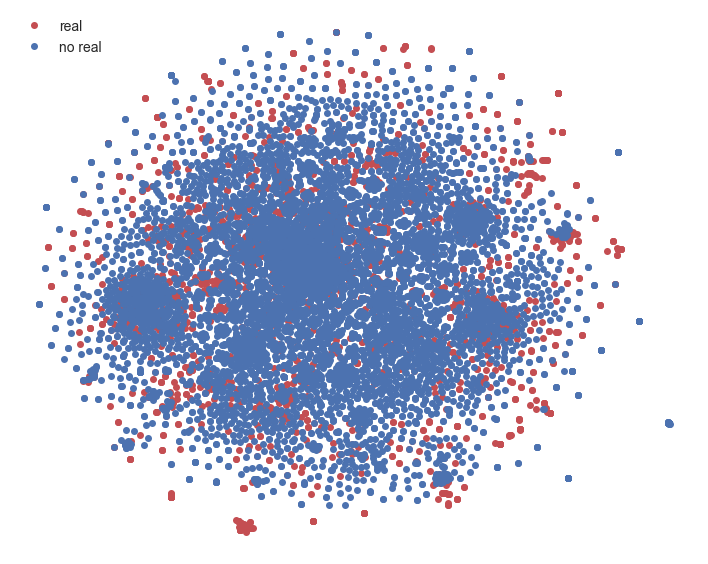

In [6]:
%run risk_tweets_nlp_feature_engineering.py

### Findings from Feature Engineering

Here are findings from feature engineering:

* I built a pipeline to engineer the features and prepare them for ML algorithms
* The transformers hyperparameter can be later optimized through model iterations
* In 2 dimensions the two classes overlap, hard to find a decision boundary

# Model Definition, Training and Evaluation

In this part of the process model I train different binary classifiers and evaluate their performance. Here are the steps for the modelling process:

* The confusion matrix is used to evaluate the performance of the classifiers. The algorithms are optimized such that the f1 score (the harmonic mean of precision and recall) is maximized
* A validation set and the ROC curves are used to compare different classifiers
* I train binary classifiers from the `scikit-learn` python package, namely `RidgeClassifier`, `SGDClassifier`, `RandomForestClassifier` and `GradientBoostingClassifier` and evaluate their performance
* I use `GridSearch` to fine-tune the models and the data process pipeline and find the optimal hyper-parameters
* I build and train two deep learning models using `keras` and evaluate their performance. The first model consists of keras `Dense` layers. The second model consists of pretrained embeddings followed by keras `Dense` layers. `Dropout` layers are used for regularization.
* The models are evaluated on the test set to calculate the generalization error

In [7]:
%%writefile risk_tweets_nlp_modelling.py
#!/usr/bin/env python

import time,os,re,csv,sys,uuid,joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.base import clone
from sklearn.metrics import roc_curve, f1_score, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from risk_tweets_nlp_etl import etl
from risk_tweets_nlp_data_exploration import save_fig
from risk_tweets_nlp_feature_engineering import MODEL_DIR
from risk_tweets_nlp_feature_engineering import SAVED_MODEL as SAVED_PIPE


RS = 42
SKLEARN_MODEL = "my_sklearn_clf.joblib"
DNN_MODEL = "my_keras_dnn.h5"
EMB_MODEL = "my_keras_emb.h5"

TFHUB_CACHE_DIR = os.path.join(os.curdir, "my_tfhub_cache")
os.environ["TFHUB_CACHE_DIR"] = TFHUB_CACHE_DIR
   

def train_ml(train_data, valid_data, y_train, y_valid, model_path=MODEL_DIR, pipe_name=SAVED_PIPE, 
             model_name=SKLEARN_MODEL, rs=RS):
    """
    train machine learning classifiers
    """
    
    print("...training machine learning classifiers")
    
    ## load transformation pipeline
    feature_engineer = joblib.load(os.path.join(model_path, pipe_name))
    
    ## compare different classifiers
    rd = RidgeClassifier()
    sg = SGDClassifier(tol=1e-3, max_iter=1000,loss="modified_huber")
    rf = RandomForestClassifier(random_state=rs)
    gb = GradientBoostingClassifier(random_state=rs)

    models, scores = {}, {}
    for name, clf in zip(["rd","rf","sg","gb"],[rd,rf,sg,gb]):
        pipe = clone(feature_engineer)
        pipe.steps.append(("clf",clf))
        models[name] = pipe
        scores[name] = cross_val_score(pipe, train_data, y_train, cv=4, scoring="f1")
        
    ## plot cross validation scores
    plt.figure(figsize=(10, 5))
    plt.plot([1]*4, scores["rd"], ".")
    plt.plot([2]*4, scores["rf"], ".")
    plt.plot([3]*4, scores["sg"], ".")
    plt.plot([4]*4, scores["gb"], ".")
    plt.boxplot([scores["rd"],scores["rf"],scores["sg"],scores["gb"]],
                labels=("RidgeClassifier","RFClassifier", "SGDClassifier","GBClassifier"))
    plt.ylabel("f1-scores", fontsize=14)
    save_fig("cross_validation_scores")
    
    ## Tune hyper-parameters
    time_start = time.time()
    param_grid = {
        'counter__max_df':[0.4,0.6,0.8],
        'counter__max_features':[2500, 5000, 10000],
        'clf__penalty':["l2", "l1", "elasticnet"]
    }

    grid = GridSearchCV(models["sg"], param_grid=param_grid, cv=3, n_jobs=-1)
    grid.fit(train_data, y_train)
    #print("train time", time.strftime('%H:%M:%S', time.gmtime(time.time()-time_start)))

    ## save model
    saved_model = os.path.join(model_path,model_name)
    joblib.dump(grid, saved_model)
    print("best parameters: {}".format(grid.best_params_))
    
    ## evaluation on the validation set
    y_pred = grid.predict(valid_data)
    #print('validation f1-score:{}'.format(f1_score(y_valid, y_pred)))
    
    
def train_deep(train_data, valid_data, y_train, y_valid, model_path=MODEL_DIR, pipe_name=SAVED_PIPE, 
             model_name=DNN_MODEL, rs=RS):
    """
    train deep learning classifiers
    """
    
    print("...training dense model")
    
    keras.backend.clear_session()
    np.random.seed(rs)
    tf.random.set_seed(rs)
    
    ## load transformation pipeline
    feature_engineer = joblib.load(os.path.join(model_path, pipe_name))
    
    ## transform the datasets
    X_train = feature_engineer.transform(train_data).todense()
    X_valid = feature_engineer.transform(valid_data).todense()
    
    ## build keras dense model
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=X_train.shape[1]))
    model.add(keras.layers.Dense(64, activation="relu"))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC()])
    model.summary()
    
    ## training
    history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), verbose=0,
                        callbacks=[keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)])

    ## save dense model
    saved_model = os.path.join(model_path,model_name)
    model.save(saved_model)
    
    ## evaluate on the validation set
    #model.evaluate(X_valid,y_valid)
    
    
def train_embed(train_data, valid_data, y_train, y_valid, model_path=MODEL_DIR, model_name=EMB_MODEL, rs=RS):
    """
    train deep learning classifier reusing pretrained embeddings
    """
    
    print("...training dense model reusing pretrained embeddings")
    
    keras.backend.clear_session()
    np.random.seed(rs)
    tf.random.set_seed(rs)
    
    ## build keras model
    model = keras.models.Sequential()
    model.add(hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim50/1",
                             dtype=tf.string, input_shape=[], output_shape=[50], trainable=True))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.2))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.AUC()])
    model.summary()
    
    ## training
    history = model.fit(train_data, y_train, epochs=10,validation_data=(valid_data, y_valid), verbose=0,
                        callbacks=[keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)])

    ## save model
    saved_model = os.path.join(model_path,model_name)
    model.save(saved_model)
    
    ## evaluate on the validation set
    #model.evaluate(valid_data,y_valid)
    
    
def plot_roc_curve(fpr, tpr, label=None):
    """
    plot ROC curves
    """
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--', label='Dummy')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    
    
def model_evaluation(input_data, target, set_name, model_path=MODEL_DIR, sklearn_model=SKLEARN_MODEL, 
                     dnn_model=DNN_MODEL, emb_model=EMB_MODEL, pipe_name=SAVED_PIPE):
    """
    evaluate the three models
    """
    
    print("Model Evaluation on the {} Set".format(set_name.upper()))
    
    ## load trained models
    clf = joblib.load(os.path.join(model_path,sklearn_model))
    dnn = keras.models.load_model(os.path.join(model_path,dnn_model))
    emb = keras.models.load_model(os.path.join(model_path,emb_model),custom_objects={'KerasLayer':hub.KerasLayer})
    
    ## load transformation pipeline
    feature_engineer = joblib.load(os.path.join(model_path, pipe_name))
    
    ## transform the input dataset (needed for the dnn model)
    X = feature_engineer.transform(input_data).todense()
    
    ## calculate scores
    clf_scores = clf.predict_proba(input_data)[:,1]
    dnn_scores = dnn.predict(X).ravel()
    emb_scores = emb.predict(input_data).ravel()
    
    ## calculate predictions
    clf_pred = clf.predict(input_data)
    dnn_pred = dnn.predict_classes(X)
    emb_pred = emb.predict_classes(input_data)
    
    ## calculate metrics
    clf_fpr, clf_tpr, clf_thresholds = roc_curve(target, clf_scores)
    dnn_fpr, dnn_tpr, dnn_thresholds = roc_curve(target, dnn_scores)
    emb_fpr, emb_tpr, emb_thresholds = roc_curve(target, emb_scores)
    
    ## plot roc curves
    plt.figure(figsize=(8, 6))
    plt.plot(clf_fpr, clf_tpr, 'r--', label='SGD')
    plt.plot(dnn_fpr, dnn_tpr, 'g--', label='DNN')
    plot_roc_curve(emb_fpr, emb_tpr, "EMB")
    plt.legend(loc='lower right')
    plt.title("{} ROC Curves".format(set_name.upper()))
    save_fig("plot_curves_{}_set".format(set_name.lower()))
    
    ## print classification report
    for name, scores, y_pred in zip(["SGD","DNN","EmbedDNN"],
                                    [clf_scores,dnn_scores,emb_scores],
                                    [clf_pred,dnn_pred,emb_pred]):
        print(name.upper())
        print(classification_report(target, y_pred))
        #print('ROC AUC:', roc_auc_score(target, scores))
        print('f1-score:{}'.format(round(f1_score(target, y_pred),2)))
    
    print("_________________________________________________________________")
    
def model_train(train_data, y_train, rs=RS):
    """
    train classifiers and select the best model
    """
    
    print("Model Training")
    
    ## create validation set from training set
    train_data, valid_data, y_train, y_valid = train_test_split(train_data, y_train, test_size=0.2,
                                                                stratify=y_train, random_state=rs)
    
    print("train", sorted(Counter(y_train).items()))
    print("valid", sorted(Counter(y_valid).items()))
    print("test", sorted(Counter(y_test).items()))
    
    ## train machine learning classifier
    train_ml(train_data, valid_data, y_train, y_valid)
    
    ## train deep learning classifier
    train_deep(train_data, valid_data, y_train, y_valid)
    
    ## train deep classifier with pretrained embeddings
    train_embed(train_data, valid_data, y_train, y_valid)
    
    ## model evaluation on validation set
    model_evaluation(valid_data, y_valid, set_name="valid")  
    
    
if __name__ == "__main__":
    
    run_start = time.time()
    
    ## load the dataset
    train_data, y_train, test_data, y_test = etl()
    
    ## model training
    model_train(train_data, y_train)
    
    ## model evaluation on test set
    model_evaluation(test_data, y_test, set_name="test")
    
    print("METADATA")
    m, s = divmod(time.time()-run_start,60)
    h, m = divmod(m, 60)
    print("...run time:", "%d:%02d:%02d"%(h, m, s))
    
    print("done")
    

Overwriting risk_tweets_nlp_modelling.py


loading .\data\processed-corpus.npz from file
Model Training
train [(0, 5930), (1, 1346)]
valid [(0, 1483), (1, 337)]
test [(0, 1853), (1, 421)]
...training machine learning classifiers
...saving figure cross_validation_scores
best parameters: {'clf__penalty': 'l2', 'counter__max_df': 0.6, 'counter__max_features': 10000}
...training dense model
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320064    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 328,513
Trainable params:

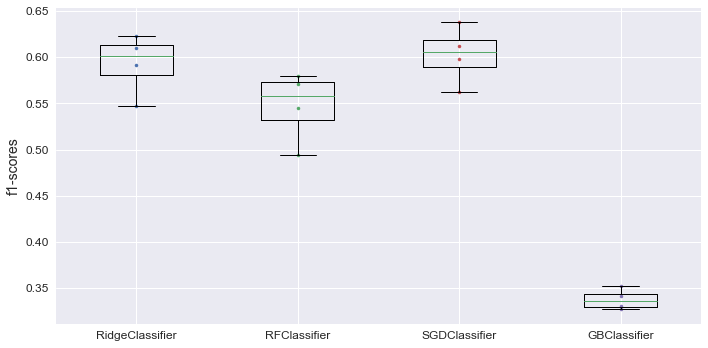

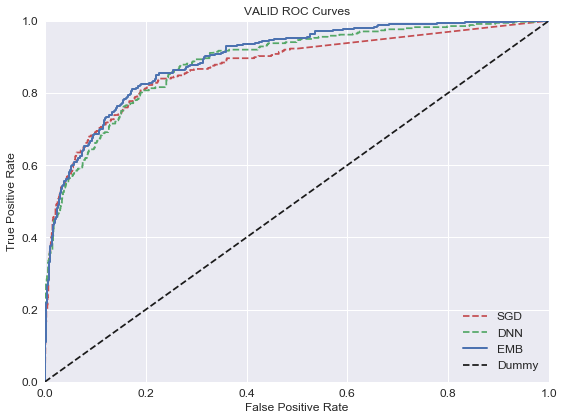

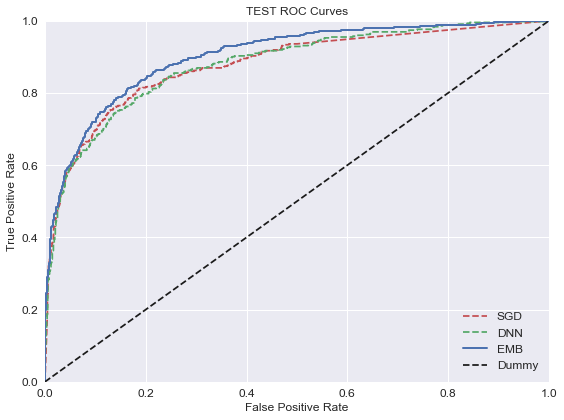

In [8]:
%run risk_tweets_nlp_modelling.py

### Findings from Model Definition and Training

Here are findings from feature engineering:

* `RidgeClassifier`, `SGDClassifier` and `RandomForestClassifier` after cross validation without hyperparameter tuning perform almost equaly on the training set with the average `f1-score` close to 0.60. The  `GradientBoostingClassifier` model underperforms
* I fine-tuned the `SGDClassifier` by tweaking the hyperparameters. The `f1-score` on the validation set is 0.64
* I trained a deep learning model with dense layers. The `f1-score` on the validation set is 0.63
* I trained a deep learning model with dense layers using pretrained embeddings. The `f1-score` on the validation set is above 0.65
* The deep model with embedding layer outperforms the other models and generalizes better
* A better lemmatizer and more data might increase model performance

# Model Deployment and Data Product

The best model is deployed and shared with the stakeholders. Here are the steps to deploy the model in production:

* I create a flask APP which runs on a localhost server
* The APP loads the best trained model (deep learning with embeddings followed by dense layers)
* Given new tweets, the flask APP predicts whether or not the tweets are for a real disaster or not 

### Create Flask APP

In [9]:
%%writefile risk_tweets_nlp_app.py

from flask import Flask, jsonify, request
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
import socket
import json
import os

from risk_tweets_nlp_etl import lemmatize_document, STOPLIST

KERAS_MODEL = "my_keras_emb.h5"
MODEL_DIR = os.path.join(".","models")

app = Flask(__name__)

@app.route("/")
def hello():
    html = "<h3>Hello {name}!</h3>" \
           "<b>Hostname:</b> {hostname}<br/>"
    return html.format(name=os.getenv("NAME", "world"), hostname=socket.gethostname())

@app.route('/predict', methods=['GET','POST'])
def predict():
    
    ## input checking
    if not request.json:
        print("ERROR: API (predict): did not receive request data")
        return jsonify([])

    query = request.json["data"]
    processed_query = [lemmatize_document(tweet, STOPLIST) for tweet in query]
    
    y_pred = model.predict_classes(processed_query)
    return(jsonify(y_pred.tolist()))
            
if __name__ == '__main__':
    saved_model = os.path.join(MODEL_DIR, KERAS_MODEL)
    model = keras.models.load_model(saved_model, custom_objects={'KerasLayer':hub.KerasLayer})
    app.run(host='localhost', port=8080,debug=True)

Overwriting risk_tweets_nlp_app.py


### Test the flask app

Move into the project directory

> $ cd project-name

Start the app

> $ python risk_tweets_nlp_app.py

Then go to http://localhost:8080/

In [ ]:
import requests
from ast import literal_eval

## create some new data
corpus = []
corpus.append(["The building is on fire, apartments are burning. Run away!"])
corpus.append(["Great place in the forest to light a fire"])

## data needs to be in dict format for JSON
query = {'data':corpus}

## test the Flask API
port = 8080
r = requests.post('http://localhost:{}/predict'.format(port),json=query)

response = literal_eval(r.text)
print(response)